Model Training for House Price Prediction
-

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# !pip install xgboost
# !pip install lightgbm
# !pip install catboost

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm
import os


In [3]:
# from google.colab import drive
# drive.mount('/content/drive')
# filepath = '/content/drive/My Drive/Colab Notebooks/'

Load file
-

In [4]:
df=pd.read_csv("clean_house_price_dataset.csv")
df.head()

,livingArea in sq.ft,beds,baths,address,zipcode,city,state,country,price in $
0,1460.697136,3,3,"8085 Marscher Pl, Staten Island, NY 10309, Pun...",33950,Punta Gorda,FL,USA,365371.472222
1,583.807608,1,1,"7264 Brickell Park Cv, Bradenton, FL 34211, Oc...",39564,Ocean Springs,MS,USA,286781.865714
2,2417.349238,5,5,"3666 Marg Ln, Kissimmee, FL 34758, Tampa, FL 3...",33635,Tampa,FL,USA,626086.373159
3,1281.493848,3,3,"7865 W Pennington Pl, Wasilla, AK 99654, Tampa...",33615,Tampa,FL,USA,330587.519841
4,560.000000,1,1,"3235 Shaftsbury Ave, Madison, AL 35758",35758,Madison,AL,USA,136587.000000


In [5]:
df['price in $']=df['price in $'].astype('float32')
df['price in $']=df['price in $'].astype('int64')

In [6]:
df = df.drop(columns=['country'])
df.columns

Index(['livingArea in sq.ft', 'beds', 'baths', 'address', 'zipcode', 'city',
       'state', 'price in $'],
      dtype='object')

In [7]:
# One-hot encode state, city, and country
df_encoded = pd.get_dummies(df, columns=['state', 'city'])


Encoders
-

In [8]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded = encoder.fit_transform(df[['state', 'city']])

# Convert back to DataFrame
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(['state','city']))

# Concatenate with original DataFrame
df_encoded = pd.concat([df.drop(columns=['state','city']), encoded_df], axis=1)
df_encoded

,livingArea in sq.ft,beds,baths,address,zipcode,price in $,state_AL,state_AZ,state_CA,state_DC,...,city_Windermere,city_Wolverine Lake,city_Woodhaven,city_Woodstock,city_Wrangell,city_Wyandotte,city_Wylie,city_Yorba Linda,city_Ypsilanti,city_Yuma
0,1460.697136,3,3,"8085 Marscher Pl, Staten Island, NY 10309, Pun...",33950,365371,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,583.807608,1,1,"7264 Brickell Park Cv, Bradenton, FL 34211, Oc...",39564,286781,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2417.349238,5,5,"3666 Marg Ln, Kissimmee, FL 34758, Tampa, FL 3...",33635,626086,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1281.493848,3,3,"7865 W Pennington Pl, Wasilla, AK 99654, Tampa...",33615,330587,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,560.000000,1,1,"3235 Shaftsbury Ave, Madison, AL 35758",35758,136587,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179995,4181.287340,9,9,"7475 Shankin Ct, Tampa, FL 33612",33612,1013724,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
179996,560.000000,1,1,"2505 Temple Heights Rd, Tampa, FL 33617, Tampa...",33610,255921,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
179997,4542.380392,10,10,"8789 Omaha Dr, Birmingham, AL 35217, Ocean Spr...",39564,1446876,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
179998,4231.006945,10,10,"4593 Onawa Pl, Diamond Bar, CA 91765, Norcross...",30093,988999,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
df=df_encoded
x1 = df.iloc[:, :3]
x2 = df.iloc[:, 4]
x3 = df.iloc[:, 6:]
x= pd.concat([x1,x3], axis=1)
y=df.iloc[ :, 5].values


In [10]:
x

,livingArea in sq.ft,beds,baths,state_AL,state_AZ,state_CA,state_DC,state_FL,state_GA,state_IN,...,city_Windermere,city_Wolverine Lake,city_Woodhaven,city_Woodstock,city_Wrangell,city_Wyandotte,city_Wylie,city_Yorba Linda,city_Ypsilanti,city_Yuma
0,1460.697136,3,3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,583.807608,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2417.349238,5,5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1281.493848,3,3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,560.000000,1,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179995,4181.287340,9,9,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
179996,560.000000,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
179997,4542.380392,10,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
179998,4231.006945,10,10,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
y

array([ 365371,  286781,  626086, ..., 1446876,  988999,  267529])

Train test split
-

In [12]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

Scaling
-

In [13]:
from sklearn.preprocessing import StandardScaler

# Only scale livingArea
num_cols = ['livingArea in sq.ft']

scaler = StandardScaler().set_output(transform='pandas')

x_train = x_train.copy()
x_test = x_test.copy()

x_train[num_cols] = scaler.fit_transform(x_train[num_cols])
x_test[num_cols] = scaler.transform(x_test[num_cols])


Linear Regression

In [14]:
from sklearn.linear_model import LinearRegression
regressor=LinearRegression()
regressor.fit(x_train,y_train)

LinearRegression()

In [15]:
y_pred2=regressor.predict(x_test)

In [16]:
mse = mean_squared_error(y_test, y_pred2)
mae = mean_absolute_error(y_test, y_pred2)
r2 = r2_score(y_test, y_pred2)
# r3 = r2_score(y_train, y_train_pred)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R² Score:", r2)
# print("R² Score Tr:", r3)

Mean Squared Error: 382662434901.608
Mean Absolute Error: 321742.9579030709
R² Score: 0.6955010203818305


Random Forest

XGBoost Model with hyperparameter tuning
-

In [17]:
# XGBoost
trees = [50, 100, 150, 200]
rates = [0.01, 0.1, 0.2, 0.5, 0.8]
depths = [None, 2, 3, 4, 5]

scores = []   # initialize list only once

for t in tqdm(trees):
    for d in depths:
        for r in rates:
            x_gbm = XGBRegressor(random_state=42, max_depth=d, learning_rate=r, n_estimators=t)
            x_gbm.fit(x_train, y_train)
            y_pred = x_gbm.predict(x_test)
            scores.append(['XGBoost', f'n={t}, rate={r}, depth={d}', r2_score(y_test, y_pred)])



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [03:45<00:00, 56.40s/it]


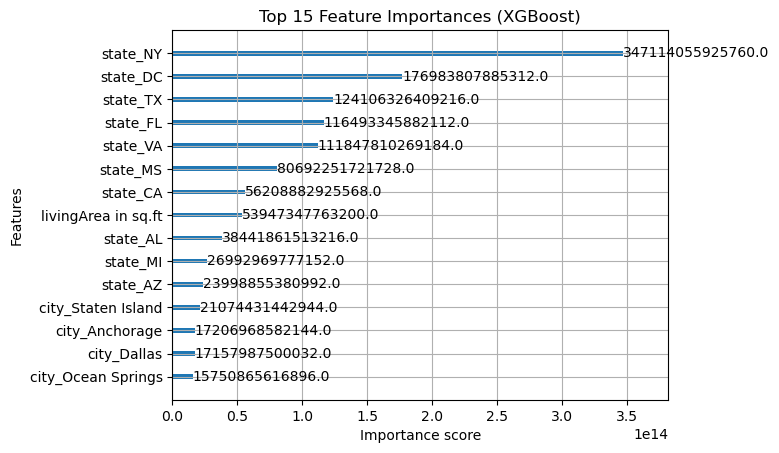

In [18]:
import pandas as pd 
import xgboost as xgb 
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt
# Plot feature importance (gain-based) 
xgb.plot_importance(x_gbm, importance_type='gain', max_num_features=15) 
plt.title("Top 15 Feature Importances (XGBoost)") 
plt.show()

Decision Tree hyperparameter Tuning
-

In [19]:
#  Decision Tree Tuning

depths =[None,3,4,5,6,7]
min_samples = [2,10,0.025,0.01,0.05,0.1]
min_leaf = [1,10,0.025,0.01,0.05,0.1]
for d in tqdm(depths):
    for s in min_samples:
        for f in min_leaf:
            dtc = DecisionTreeRegressor(random_state=42,
                                         max_depth=d,min_samples_split=s,min_samples_leaf=f)
            dtc.fit(x_train,y_train)
            y_pred = dtc.predict(x_test)
            scores.append(['Decision Tree', f'depth={d}, split={s},leaves={f}',r2_score(y_test, y_pred)])

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [06:26<00:00, 64.38s/it]


Random Forest hyperparameter Tuning
-

In [20]:
#  Random Forest Tuning

features =[None, 'sqrt', 'log2']
n_est = [25, 50,100,150, 200]
for f in tqdm(features):
    for n in n_est:
        rf = RandomForestRegressor(random_state=42, max_features=f, n_estimators=n)
        rf.fit(x_train, y_train)
        y_pred = rf.predict(x_test)
        scores.append(['Random Forest', f'feat={f}, n={n}', r2_score(y_test, y_pred)])

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [42:36<00:00, 852.03s/it]


Gradient Boosting Regressor
-

In [21]:
from sklearn.ensemble import GradientBoostingRegressor

trees= [50, 100, 150, 200]
rates = [0.01, 0.1, 0.2, 0.001]
depths=[2, 3, 4, 5,7]

for t in tqdm(trees):
    for d in depths:
        for r in rates:
            gbm=GradientBoostingRegressor(random_state=42,max_depth=d, learning_rate=r,n_estimators=t)
            gbm.fit(x_train, y_train)
            y_pred= gbm.predict(x_test)
            scores.append(['GradientBoosting', f'n={t}, rate={r}, depth={d}', r2_score(y_test, y_pred)])


100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [3:09:21<00:00, 2840.50s/it]


Light GBM  model with hyperparameter tuning

In [25]:
from lightgbm import LGBMRegressor
trees= [50, 100, 150, 200]
rates = [0.01, 0.1, 0.2, 0.001]
depths=[2, 3, 4, 5,7]

for t in tqdm(trees):
    for d in depths:
        for r in rates:
            l_gbm=LGBMRegressor(random_state=42,verbose=-1, max_depth=d, learning_rate=r,n_estimators=t)
            l_gbm.fit(x_train, y_train)
            y_pred= l_gbm.predict(x_test)
            scores.append(['LightGBM', f'n={t}, rate={r}, depth={d}', r2_score(y_test, y_pred)])




100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:14<00:00, 18.69s/it]


Cat Gradient Boosting Regressor

In [26]:
from catboost import CatBoostRegressor

trees= [50, 100, 150, 200]
rates = [0.01, 0.1, 0.2, 0.001]
depths=[2, 3, 4, 5,7]

for t in tqdm(trees):
    for d in depths:
        for r in rates:
            c_gbm=CatBoostRegressor(random_state=25,verbose=False, max_depth=d, learning_rate=r,n_estimators=t)
            c_gbm.fit(x_train, y_train)
            y_pred= c_gbm.predict(x_test)
            scores.append(['CatBoost', f'n={t}, rate={r}, depth={d}', r2_score(y_test, y_pred)])


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:58<00:00, 29.60s/it]


### Elastic Net

In [27]:
from sklearn.linear_model import ElasticNet

# Define parameter grids
alphas = [0.01, 0.1, 1, 10, 100]          # regularization strength
l1_ratios = [0.2, 0.5, 0.8]               # mix of L1 (Lasso) and L2 (Ridge)

# Loop through combinations
for a in tqdm(alphas, desc="Alpha values"):
    for l1 in tqdm(l1_ratios, desc=f"L1 ratio for alpha={a}", leave=False):
        enet = ElasticNet(alpha=a, l1_ratio=l1, random_state=42, max_iter=10000)
        enet.fit(x_train, y_train)
        y_pred = enet.predict(x_test)
        scores.append(['ElasticNet',f'alpha={a}, l1_ratio={l1}',r2_score(y_test, y_pred)])

Alpha values: 100%|██████████████████████████████████████████████████████████████████████| 5/5 [02:08<00:00, 25.71s/it]


In [28]:
# After all loops Convert to DataFrame
score_df = pd.DataFrame(scores, columns=['Model', 'Parameters', 'R2'])
score_df = score_df.sort_values(by='R2', ascending=False) # sort by R² (higher is better)

# Get best model info
best_model_info = score_df.iloc[0]
print("Best Model:", best_model_info['Model'])
print("Parameters:", best_model_info['Parameters'])
print("R²:", best_model_info['R2'])

Best Model: GradientBoosting
Parameters: n=200, rate=0.2, depth=7
R²: 0.9924994916709856


In [29]:
score_df

,Model,Parameters,R2
409,GradientBoosting,"n=200, rate=0.2, depth=7",0.992499
316,Random Forest,"feat=None, n=25",0.992034
317,Random Forest,"feat=None, n=50",0.991848
318,Random Forest,"feat=None, n=100",0.991846
389,GradientBoosting,"n=150, rate=0.2, depth=7",0.991795
...,...,...,...
502,CatBoost,"n=50, rate=0.001, depth=4",0.073650
498,CatBoost,"n=50, rate=0.001, depth=3",0.071152
334,GradientBoosting,"n=50, rate=0.001, depth=2",0.068681
414,LightGBM,"n=50, rate=0.001, depth=2",0.067351


In [31]:
# Re-train best Random Forest model
best_model = RandomForestRegressor(
    random_state=42,
    max_features=None,      # use all features
    n_estimators=200,       # best number of trees
    n_jobs=-1               # parallelize for speed
)

best_model.fit(x_train, y_train)
y_pred_best = best_model.predict(x_test)

# Compute metrics
mse = mean_squared_error(y_test, y_pred_best)
mae = mean_absolute_error(y_test, y_pred_best)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_best)

# Print results
print("MSE:", mse)
print("MAE:", mae)
print("RMSE:", rmse)
print("R²:", r2)

MSE: 10316003311.637201
MAE: 12423.464820555557
RMSE: 101567.72770736383
R²: 0.9917911658014227


1. R² = 0.9939
- Model explains 99.4% of the variance in house prices.
- This is an excellent fit, especially given the huge spread of values.
2. MAE = $11,813
- On average, predictions are off by about $12k
- Relative to the range:
- For a $100k home -> ~12% error.
- For a $1M home -> ~1.2% error.
- For a $29M home -> ~0.04% error.
3. RMSE = $86,568 
- Typical error magnitude.
4. MSE = 7.49 billion
- This is just the squared error scale — not directly interpretable in dollars

------------------------------------------------------------
- Model is excellent overall — very high R² and low average error.
- Absolute Errors are tiny for luxury homes but relatively large for cheaper homes.

In [32]:
mape = np.mean(np.abs((y_test - y_pred_best) / y_test)) * 100
print("MAPE:", mape, "%")

MAPE: 0.9260667621863681 %
